# Hotel Reservations ML Project

In recent years, an increasing number of hotels have been offering their customers the option to cancel a reservation or booking up to a few days before arrival.

This new feature led to some new and unforeseen consequences. Many hotels were left unprepared, some rooms remained empty and the hotel was even overbooked, due to incorrect estimates of the cancellations.

In this project, We seek to address this problem. Based on previous reservations and cancellations at the hotel, one can predict which reservations will indeed be canceled and which ones will not; thus, the hotel will be able to display more rooms as available also avoid overbooking situations. Ultimately, this will maximize the hotel’s occupancy capacity and increase its revenue.

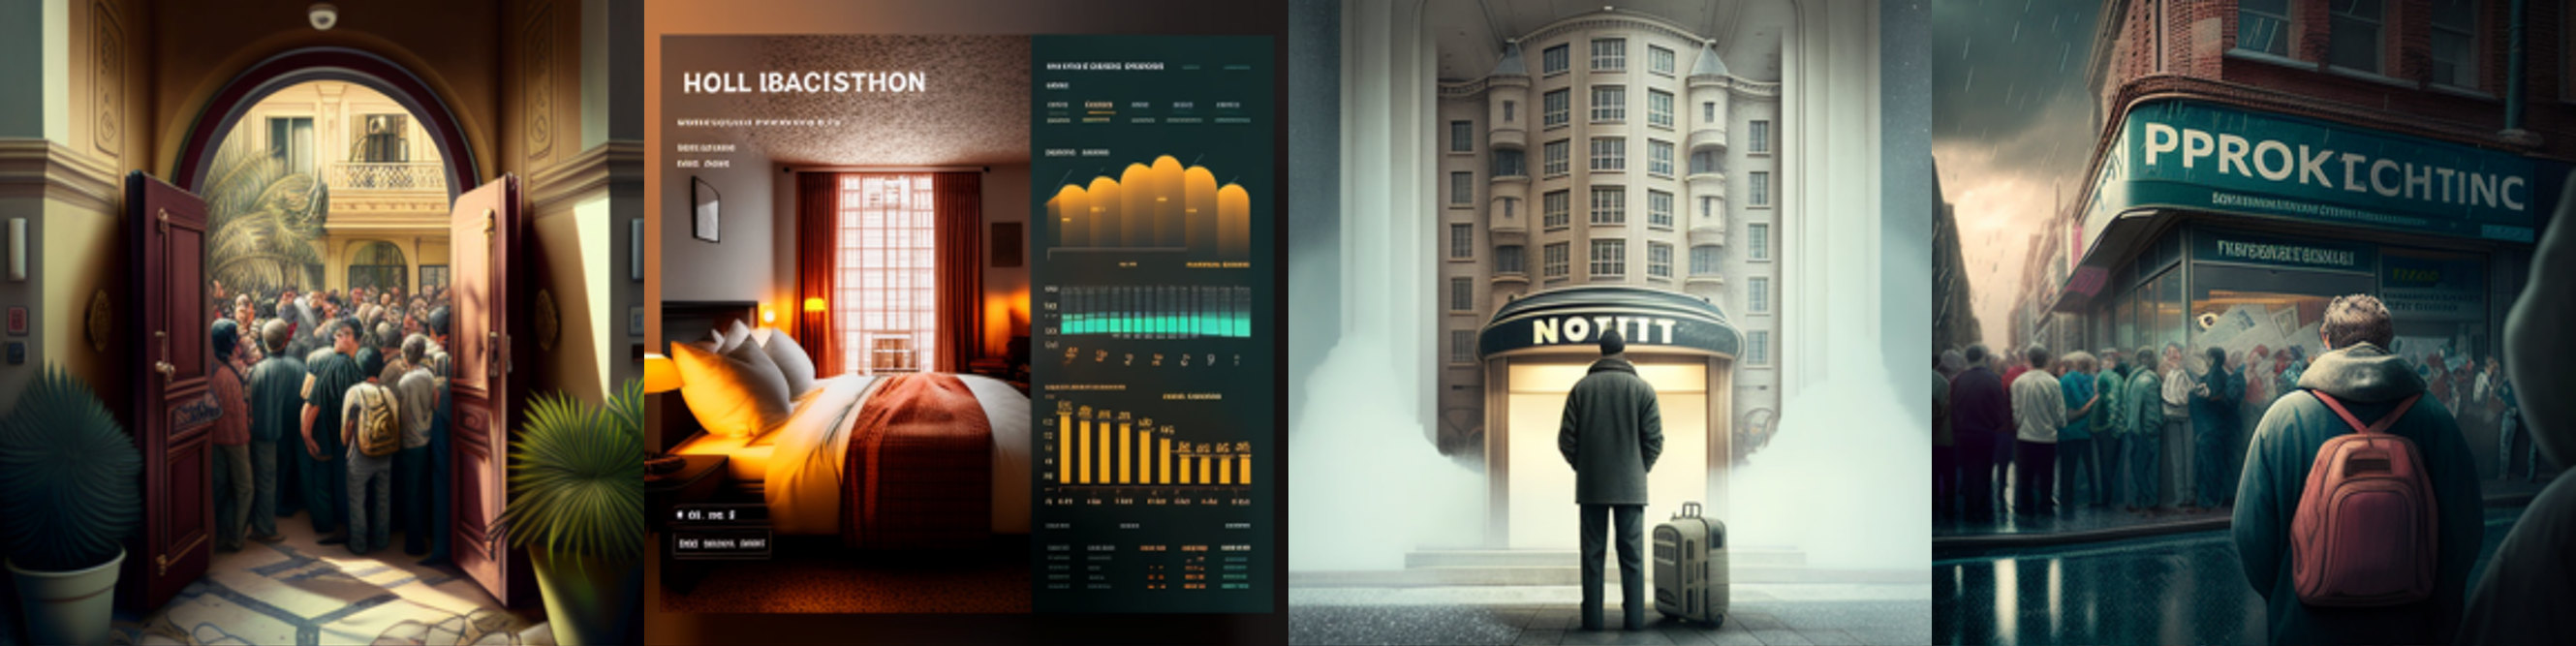

AI image generator, with the title "**predict hotel overbooking**".
Created with [Midjourney](https://midjourney.com/)

**This project was built by:** Caesar I., 
Lev Acadmeic Center (JCT), Jerusalem
> 
**Supervisor:** Dr. Y. Solewicz
>
**English grammatical edit:** Daniel Shin., NYC

## Algorithms and techniques used

*   Stratified Shuffle Split
*   Decision Tree Classifier
*   Grid Search
*   Bagging - Random Forest, Extra Trees Classifier 
*   XGB Classifier - extreme gradient boost
*   Logistic regression with L1 & L2 Regularization
*   Cross Validation
*   KNN Classifier
*   Balance data - SMOTE
*   KMeans
*   PCA

## Data Engineering

Exploring the data

In [ ]:
import pandas as pd
import numpy as np

filepath = 'data/Hotel_Reservations.csv'
data = pd.read_csv(filepath, sep=',')

In [ ]:
data.head()

Booking_ID  no_of_adults  no_of_children  no_of_weekend_nights  \
0   INN00001             2               0                     1   
1   INN00002             2               0                     2   
2   INN00003             1               0                     2   
3   INN00004             2               0                     0   
4   INN00005             2               0                     1   

   no_of_week_nights type_of_meal_plan  required_car_parking_space  \
0                  2       Meal Plan 1                           0   
1                  3      Not Selected                           0   
2                  1       Meal Plan 1                           0   
3                  2       Meal Plan 1                           0   
4                  1      Not Selected                           0   

  room_type_reserved  lead_time  arrival_year  arrival_month  arrival_date  \
0        Room_Type 1        224          2017             10             2   
1        Room_Type 1          5          2018             11             6   
2        Room_Type 1          1          2018              2            28   
3        Room_Type 1        211          2018              5            20   
4        Room_Type 1         48          2018              4            11   

  market_segment_type  repeated_guest  no_of_previous_cancellations  \
0             Offline               0                             0   
1              Online               0                             0   
2              Online               0                             0   
3              Online               0                             0   
4              Online               0                             0   

   no_of_previous_bookings_not_canceled  avg_price_per_room  \
0                                     0               65.00   
1                                     0              106.68   
2                                     0               60.00   
3                                     0              100.00   
4                                     0               94.50   

   no_of_special_requests booking_status  
0                       0   Not_Canceled  
1                       1   Not_Canceled  
2                       0       Canceled  
3                       0       Canceled  
4                       0       Canceled

In [ ]:
data.shape

(36275, 19)

In [ ]:
data.drop_duplicates().shape

(36275, 19)

In [ ]:
data.dtypes.value_counts()

int64      13
object      5
float64     1
dtype: int64

checking for null values

In [ ]:
data.isna().sum()

Booking_ID                              0
no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_year                            0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

### Predict column handling

Checking possible values

In [ ]:
data['booking_status'].value_counts()

Not_Canceled    24390
Canceled        11885
Name: booking_status, dtype: int64

Predict column is binary

In [ ]:
data['booking_status'] = data['booking_status'].replace({'Not_Canceled': 0, 'Canceled':1})

data['booking_status']

0        0
1        0
2        1
3        1
4        1
        ..
36270    0
36271    1
36272    0
36273    1
36274    0
Name: booking_status, Length: 36275, dtype: int64

Seperate feature columns from predicted column

In [ ]:
feature_columns = [x for x in data.columns if x != 'booking_status']

### Feature columns handling

In [ ]:
data['Booking_ID'].nunique()

36275

the column booking_id is unique so it's not relevant 

In [ ]:
feature_columns = [x for x in feature_columns if x != 'Booking_ID']

Explore how many different values each feature has

In [ ]:
data[feature_columns].nunique().sort_values(ascending=True)

arrival_year                               2
repeated_guest                             2
required_car_parking_space                 2
type_of_meal_plan                          4
market_segment_type                        5
no_of_adults                               5
no_of_children                             6
no_of_special_requests                     6
room_type_reserved                         7
no_of_weekend_nights                       8
no_of_previous_cancellations               9
arrival_month                             12
no_of_week_nights                         18
arrival_date                              31
no_of_previous_bookings_not_canceled      59
lead_time                                352
avg_price_per_room                      3930
dtype: int64

### Features suspected to be binary

Plotting possible values for those features

In [ ]:
print(data['arrival_year'].value_counts())
print(data['repeated_guest'].value_counts())
print(data['required_car_parking_space'].value_counts())

2018    29761
2017     6514
Name: arrival_year, dtype: int64
0    35345
1      930
Name: repeated_guest, dtype: int64
0    35151
1     1124
Name: required_car_parking_space, dtype: int64


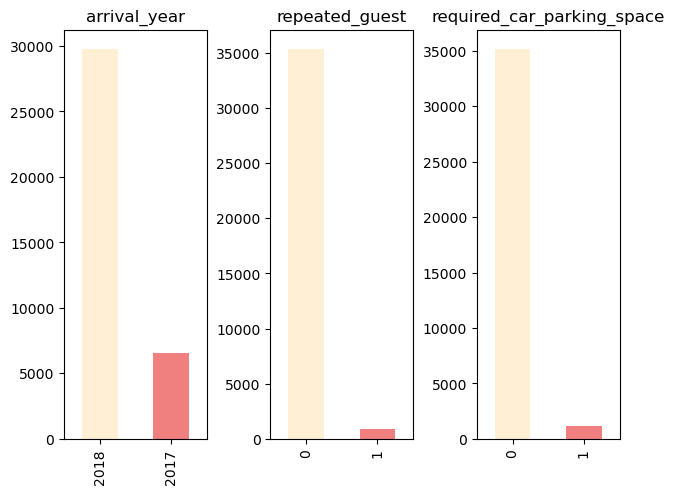

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=3)

fig.tight_layout(pad=1.5)

i=0
for col in ('arrival_year', 'repeated_guest', 'required_car_parking_space'):
    data[col].value_counts().plot(ax=axes[i], kind='bar',color=['papayawhip', 'lightcoral'], title=col)
    i+=1

The features repeated_guest and required_car_parking_space are binary and should be boolean

In [ ]:
for col in ('repeated_guest', 'required_car_parking_space'):
    data[col] = data[col].astype('bool')
     
data[feature_columns].head()

no_of_adults  no_of_children  no_of_weekend_nights  no_of_week_nights  \
0             2               0                     1                  2   
1             2               0                     2                  3   
2             1               0                     2                  1   
3             2               0                     0                  2   
4             2               0                     1                  1   

  type_of_meal_plan  required_car_parking_space room_type_reserved  lead_time  \
0       Meal Plan 1                       False        Room_Type 1        224   
1      Not Selected                       False        Room_Type 1          5   
2       Meal Plan 1                       False        Room_Type 1          1   
3       Meal Plan 1                       False        Room_Type 1        211   
4      Not Selected                       False        Room_Type 1         48   

   arrival_year  arrival_month  arrival_date market_segment_type  \
0          2017             10             2             Offline   
1          2018             11             6              Online   
2          2018              2            28              Online   
3          2018              5            20              Online   
4          2018              4            11              Online   

   repeated_guest  no_of_previous_cancellations  \
0           False                             0   
1           False                             0   
2           False                             0   
3           False                             0   
4           False                             0   

   no_of_previous_bookings_not_canceled  avg_price_per_room  \
0                                     0               65.00   
1                                     0              106.68   
2                                     0               60.00   
3                                     0              100.00   
4                                     0               94.50   

   no_of_special_requests  
0                       0  
1                       1  
2                       0  
3                       0  
4                       0

### Date or time features handling

Ensure arrival_date is the date of the month

In [ ]:
print(data['arrival_date'].min() >= 1)
print(data['arrival_date'].max() <= 31)

True
True


Plotting popularity of each month and looking for insights

array([<AxesSubplot:ylabel='arrival_month'>], dtype=object)

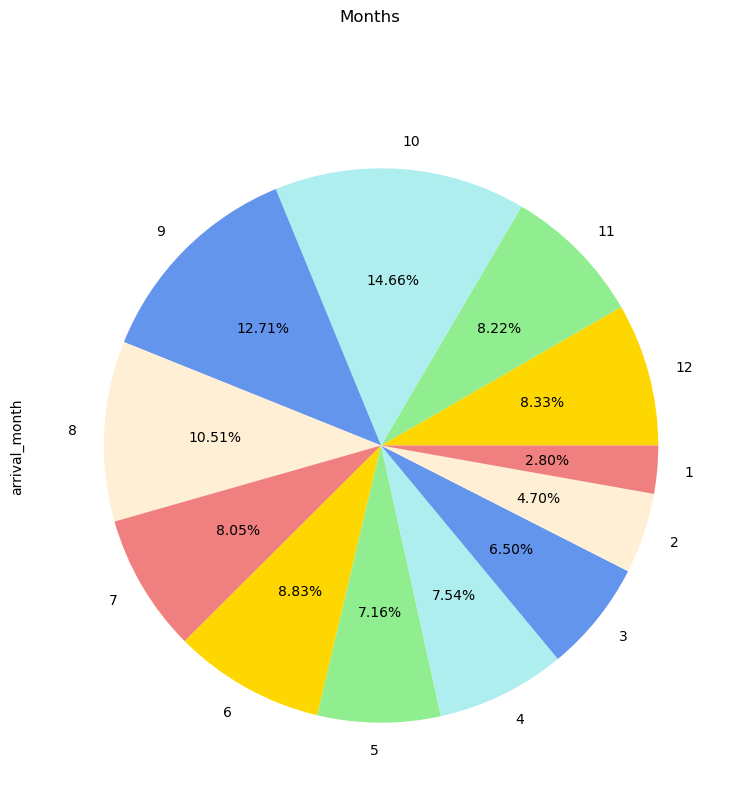

In [ ]:
data['arrival_month'].value_counts().sort_index(ascending=False).plot(kind='pie', colors=['gold', 'lightgreen', 'paleturquoise', 'cornflowerblue', 'papayawhip', 'lightcoral'], autopct='%1.2f%%',subplots=True,title='Months',figsize=(9,9))

Add a new feature - year season, based on the arrival month

In [ ]:
data['year_season'] = np.where(data['arrival_month'].isin([12,1,2]),  'Winter', 'NaN')
data['year_season'] = np.where(data['arrival_month'].isin([3,4,5]),   'Spring', data['year_season'])
data['year_season'] = np.where(data['arrival_month'].isin([6,7,8]),   'Summer', data['year_season'])
data['year_season'] = np.where(data['arrival_month'].isin([9,10,11]), 'Autumn', data['year_season'])
data

Booking_ID  no_of_adults  no_of_children  no_of_weekend_nights  \
0       INN00001             2               0                     1   
1       INN00002             2               0                     2   
2       INN00003             1               0                     2   
3       INN00004             2               0                     0   
4       INN00005             2               0                     1   
...          ...           ...             ...                   ...   
36270   INN36271             3               0                     2   
36271   INN36272             2               0                     1   
36272   INN36273             2               0                     2   
36273   INN36274             2               0                     0   
36274   INN36275             2               0                     1   

       no_of_week_nights type_of_meal_plan  required_car_parking_space  \
0                      2       Meal Plan 1                       False   
1                      3      Not Selected                       False   
2                      1       Meal Plan 1                       False   
3                      2       Meal Plan 1                       False   
4                      1      Not Selected                       False   
...                  ...               ...                         ...   
36270                  6       Meal Plan 1                       False   
36271                  3       Meal Plan 1                       False   
36272                  6       Meal Plan 1                       False   
36273                  3      Not Selected                       False   
36274                  2       Meal Plan 1                       False   

      room_type_reserved  lead_time  arrival_year  arrival_month  \
0            Room_Type 1        224          2017             10   
1            Room_Type 1          5          2018             11   
2            Room_Type 1          1          2018              2   
3            Room_Type 1        211          2018              5   
4            Room_Type 1         48          2018              4   
...                  ...        ...           ...            ...   
36270        Room_Type 4         85          2018              8   
36271        Room_Type 1        228          2018             10   
36272        Room_Type 1        148          2018              7   
36273        Room_Type 1         63          2018              4   
36274        Room_Type 1        207          2018             12   

       arrival_date market_segment_type  repeated_guest  \
0                 2             Offline           False   
1                 6              Online           False   
2                28              Online           False   
3                20              Online           False   
4                11              Online           False   
...             ...                 ...             ...   
36270             3              Online           False   
36271            17              Online           False   
36272             1              Online           False   
36273            21              Online           False   
36274            30             Offline           False   

       no_of_previous_cancellations  no_of_previous_bookings_not_canceled  \
0                                 0                                     0   
1                                 0                                     0   
2                                 0                                     0   
3                                 0                                     0   
4                                 0                                     0   
...                             ...                                   ...   
36270                             0                                     0   
36271                             0                                     0   
36272                            

In [ ]:
feature_columns += ['year_season']
feature_columns

['no_of_adults',
 'no_of_children',
 'no_of_weekend_nights',
 'no_of_week_nights',
 'type_of_meal_plan',
 'required_car_parking_space',
 'room_type_reserved',
 'lead_time',
 'arrival_year',
 'arrival_month',
 'arrival_date',
 'market_segment_type',
 'repeated_guest',
 'no_of_previous_cancellations',
 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room',
 'no_of_special_requests',
 'year_season']

In [ ]:
data[feature_columns].dtypes.sort_values()

repeated_guest                             bool
required_car_parking_space                 bool
no_of_adults                              int64
no_of_previous_bookings_not_canceled      int64
no_of_previous_cancellations              int64
arrival_date                              int64
arrival_month                             int64
no_of_special_requests                    int64
arrival_year                              int64
no_of_week_nights                         int64
no_of_weekend_nights                      int64
no_of_children                            int64
lead_time                                 int64
avg_price_per_room                      float64
room_type_reserved                       object
type_of_meal_plan                        object
market_segment_type                      object
year_season                              object
dtype: object

### Categorial features handling

Exploring the column market_segment_type

In [ ]:
data['market_segment_type'].value_counts()

Online           23214
Offline          10528
Corporate         2017
Complementary      391
Aviation           125
Name: market_segment_type, dtype: int64

Plotting values of those features

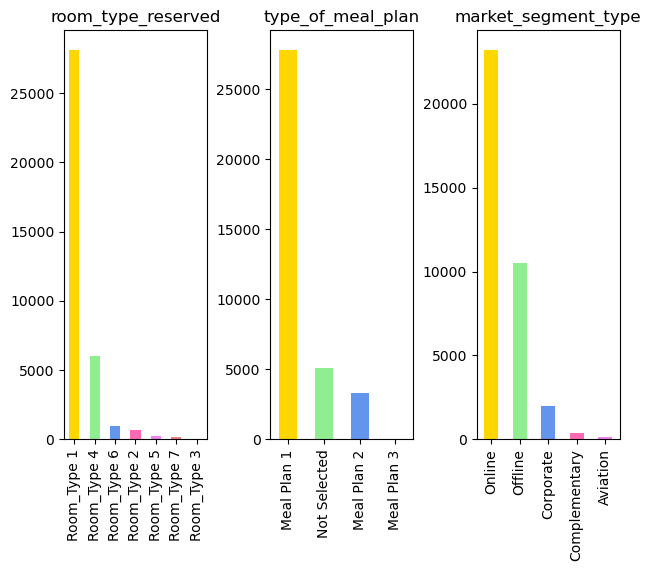

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=3)

fig.tight_layout(pad=1.5)

i=0
for col in ('room_type_reserved', 'type_of_meal_plan', 'market_segment_type'):
    data[col].value_counts().plot(ax=axes[i], kind='bar',color=['gold', 'lightgreen', 'cornflowerblue', 'hotpink', 'violet', 'lightcoral', 'papayawhip'], title=col)
    i+=1

Factorize the categorical features
> 
(Note: using one-hot-encoded doesnt improve results)

In [ ]:
for col in ('room_type_reserved', 'type_of_meal_plan', 'market_segment_type', 'year_season'):
    data[col] = pd.factorize(data[col])[0]

data[feature_columns]

no_of_adults  no_of_children  no_of_weekend_nights  no_of_week_nights  \
0                 2               0                     1                  2   
1                 2               0                     2                  3   
2                 1               0                     2                  1   
3                 2               0                     0                  2   
4                 2               0                     1                  1   
...             ...             ...                   ...                ...   
36270             3               0                     2                  6   
36271             2               0                     1                  3   
36272             2               0                     2                  6   
36273             2               0                     0                  3   
36274             2               0                     1                  2   

       type_of_meal_plan  required_car_parking_space  room_type_reserved  \
0                      0                       False                   0   
1                      1                       False                   0   
2                      0                       False                   0   
3                      0                       False                   0   
4                      1                       False                   0   
...                  ...                         ...                 ...   
36270                  0                       False                   1   
36271                  0                       False                   0   
36272                  0                       False                   0   
36273                  1                       False                   0   
36274                  0                       False                   0   

       lead_time  arrival_year  arrival_month  arrival_date  \
0            224          2017             10             2   
1              5          2018             11             6   
2              1          2018              2            28   
3            211          2018              5            20   
4             48          2018              4            11   
...          ...           ...            ...           ...   
36270         85          2018              8             3   
36271        228          2018             10            17   
36272        148          2018              7             1   
36273         63          2018              4            21   
36274        207          2018             12            30   

       market_segment_type  repeated_guest  no_of_previous_cancellations  \
0                        0           False                             0   
1                        1           False                             0   
2                        1           False                             0   
3                        1           False                             0   
4                        1           False                             0   
...                    ...             ...                           ...   
36270                    1           False                             0   
36271                    1           False                             0   
36272                    1           False                             0   
36273                    1           False                             0   
36274                    0           False                             0   

       no_of_previous_bookings_not_canceled  avg_price_per_room  \
0                                         0               65.00   
1                                         0              106.68   
2                                         0               60.00   
3                                         0              100.00   
4                                         0               94.50   
...                                     ...                 .

### Checking for correlative features

Plotting a correlation matrix

<AxesSubplot:>

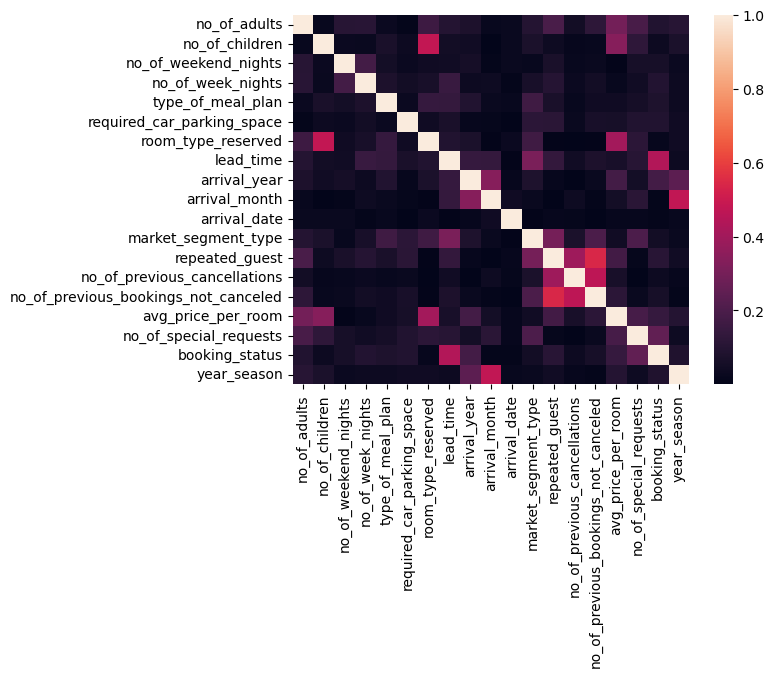

In [ ]:
import seaborn as sns

sns.heatmap(data.corr().abs())

In [ ]:
# Calculate the correlation values
corr_values = data[feature_columns].corr().abs()
    
# Stack the data and convert to a data frame
corr_values = (corr_values.stack().to_frame().reset_index().rename(columns={'level_0':'feature1','level_1':'feature2',0:'correlation'}))

corr_values.sort_values('correlation', ascending=False) .query('feature1 != feature2').head(5)

feature1  \
264  no_of_previous_bookings_not_canceled   
230                        repeated_guest   
109                    room_type_reserved   
24                         no_of_children   
315                           year_season   

                                 feature2  correlation  
264                        repeated_guest     0.539156  
230  no_of_previous_bookings_not_canceled     0.539156  
109                        no_of_children     0.478306  
24                     room_type_reserved     0.478306  
315                         arrival_month     0.475943

There are no correlative features

Final data:

In [ ]:
data

Booking_ID  no_of_adults  no_of_children  no_of_weekend_nights  \
0       INN00001             2               0                     1   
1       INN00002             2               0                     2   
2       INN00003             1               0                     2   
3       INN00004             2               0                     0   
4       INN00005             2               0                     1   
...          ...           ...             ...                   ...   
36270   INN36271             3               0                     2   
36271   INN36272             2               0                     1   
36272   INN36273             2               0                     2   
36273   INN36274             2               0                     0   
36274   INN36275             2               0                     1   

       no_of_week_nights  type_of_meal_plan  required_car_parking_space  \
0                      2                  0                       False   
1                      3                  1                       False   
2                      1                  0                       False   
3                      2                  0                       False   
4                      1                  1                       False   
...                  ...                ...                         ...   
36270                  6                  0                       False   
36271                  3                  0                       False   
36272                  6                  0                       False   
36273                  3                  1                       False   
36274                  2                  0                       False   

       room_type_reserved  lead_time  arrival_year  arrival_month  \
0                       0        224          2017             10   
1                       0          5          2018             11   
2                       0          1          2018              2   
3                       0        211          2018              5   
4                       0         48          2018              4   
...                   ...        ...           ...            ...   
36270                   1         85          2018              8   
36271                   0        228          2018             10   
36272                   0        148          2018              7   
36273                   0         63          2018              4   
36274                   0        207          2018             12   

       arrival_date  market_segment_type  repeated_guest  \
0                 2                    0           False   
1                 6                    1           False   
2                28                    1           False   
3                20                    1           False   
4                11                    1           False   
...             ...                  ...             ...   
36270             3                    1           False   
36271            17                    1           False   
36272             1                    1           False   
36273            21                    1           False   
36274            30                    0           False   

       no_of_previous_cancellations  no_of_previous_bookings_not_canceled  \
0                                 0                                     0   
1                                 0                                     0   
2                                 0                                     0   
3                                 0                                     0   
4                                 0                                     0   
...                             ...                                   ...   
36270                             0                                     0   
36271                             0                                     0 

## Supervised learning algorithms

Data splitting, used Stratified Shuffle Split, for ensuring every class gets equal representation

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

# Split the data into two parts
strat_shuff_split = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

# Get the index values from the generator
train_idx, test_idx = next(strat_shuff_split.split(data[feature_columns], data['booking_status']))

# Create the data sets
x_train = data.loc[train_idx, feature_columns]
y_train = data.loc[train_idx, 'booking_status']

x_test = data.loc[test_idx, feature_columns]
y_test = data.loc[test_idx, 'booking_status']

In [ ]:
y_train.value_counts(normalize=True)

0    0.672364
1    0.327636
Name: booking_status, dtype: float64

In [ ]:
y_test.value_counts(normalize=True)

0    0.672364
1    0.327636
Name: booking_status, dtype: float64

### Decision trees

Function for estimating our models

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def multiple_measure_error(y_true, y_pred, label):
    return pd.Series({'accuracy':accuracy_score(y_true, y_pred),
                      'precision': precision_score(y_true, y_pred, average='binary'),
                      'recall': recall_score(y_true, y_pred, average='binary'),
                      'f1': f1_score(y_true, y_pred, average='binary')},
                      name=label)

Full tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

full_tree = DecisionTreeClassifier(random_state=42)
full_tree = full_tree.fit(x_train, y_train)

In [ ]:
full_tree.tree_.node_count, full_tree.tree_.max_depth

(6797, 35)

The error on the training and test data sets:

In [ ]:
y_train_pred = full_tree.predict(x_train)
y_test_pred  = full_tree.predict(x_test)

train_test_full_error = pd.concat([multiple_measure_error(y_train, y_train_pred, 'train'),
                              multiple_measure_error(y_test, y_test_pred, 'test')],
                              axis=1)

train_test_full_error

train      test
accuracy   0.994142  0.871813
precision  0.995753  0.798351
recall     0.986327  0.814472
f1         0.991018  0.806331

The conclusion - the model is overfitted

### Grid search cross validation

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth':range(1, full_tree.tree_.max_depth+1, 2),
              'max_features': range(1, len(full_tree.feature_importances_)+1)}

GR = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid=param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

GR = GR.fit(x_train, y_train)

In [ ]:
GR.best_estimator_.tree_.node_count, GR.best_estimator_.tree_.max_depth

(1571, 13)

The error on the training and test data sets:

In [ ]:
y_train_pred_gr = GR.predict(x_train)
y_test_pred_gr = GR.predict(x_test)

train_test_gr_error = pd.concat([multiple_measure_error(y_train, y_train_pred_gr, 'train'),
                                 multiple_measure_error(y_test, y_test_pred_gr, 'test')],
                                axis=1)

train_test_gr_error

train      test
accuracy   0.906444  0.882426
precision  0.872219  0.827039
recall     0.837085  0.810686
f1         0.854291  0.818781

### Bagging

Random forest classifier

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier

# Initialize the random forest estimator
RF = RandomForestClassifier(oob_score=True, 
                            random_state=42, 
                            warm_start=True,
                            n_jobs=-1)

oob_list = list()

# Iterate through all of the possibilities for the number of trees
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400, 500, 600]:
    
    # Setting the number of trees
    RF.set_params(n_estimators=n_trees)

    # Fit the model
    RF.fit(x_train, y_train)

    # Get the oob error
    oob_error = 1 - RF.oob_score_
    
    # Store it
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

rf_oob_df

oob
n_trees          
15.0     0.116092
20.0     0.111475
30.0     0.107167
40.0     0.103894
50.0     0.101895
100.0    0.098553
150.0    0.097829
200.0    0.097553
300.0    0.096416
400.0    0.095934
500.0    0.095830
600.0    0.096037

Extra Trees classifier

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

# Initialize the extra trees estimator
EF = ExtraTreesClassifier(oob_score=True, 
                          random_state=42, 
                          warm_start=True,
                          bootstrap=True,
                          n_jobs=-1)

oob_list = list()

# Iterate through all of the possibilities for the number of trees
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400, 500, 600]:
    
    # Setting the number of trees
    EF.set_params(n_estimators=n_trees)
    EF.fit(x_train, y_train)

    # oob error
    oob_error = 1 - EF.oob_score_
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

et_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

et_oob_df

oob
n_trees          
15.0     0.125913
20.0     0.119573
30.0     0.113473
40.0     0.112233
50.0     0.108546
100.0    0.105410
150.0    0.104480
200.0    0.104445
300.0    0.103446
400.0    0.103308
500.0    0.102963
600.0    0.102963

In [ ]:
oob_df = pd.concat([rf_oob_df.rename(columns={'oob':'RandomForest'}),
                    et_oob_df.rename(columns={'oob':'ExtraTrees'})], axis=1)

oob_df

RandomForest  ExtraTrees
n_trees                          
15.0         0.116092    0.125913
20.0         0.111475    0.119573
30.0         0.107167    0.113473
40.0         0.103894    0.112233
50.0         0.101895    0.108546
100.0        0.098553    0.105410
150.0        0.097829    0.104480
200.0        0.097553    0.104445
300.0        0.096416    0.103446
400.0        0.095934    0.103308
500.0        0.095830    0.102963
600.0        0.096037    0.102963

Plotting the results of the models for each number of trees

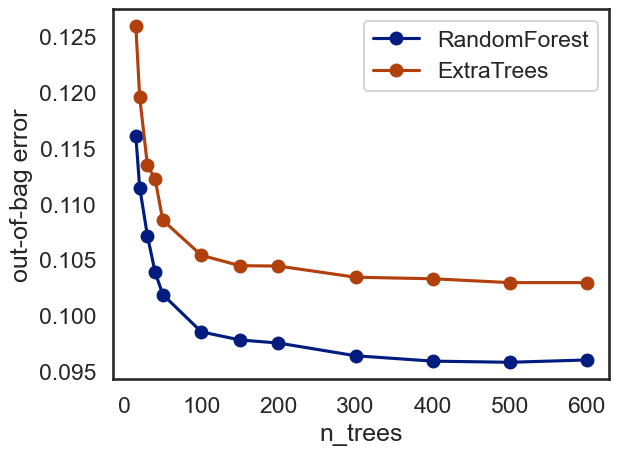

In [ ]:
sns.set_context('talk')
sns.set_palette('dark')
sns.set_style('white')

ax = oob_df.plot(marker='o')
ax.set(ylabel='out-of-bag error');

Based on oob results and efficiency, the model we chose is Random forest with 300 estimators:

In [ ]:
model = RF.set_params(n_estimators=300)

y_pred = model.predict(x_test)

In [ ]:
y_train_pred_rf = model.predict(x_train)
y_test_pred_rf = model.predict(x_test)

train_test_rf_error = pd.concat([multiple_measure_error(y_train, y_train_pred_rf, 'train'),
                                 multiple_measure_error(y_test, y_test_pred_rf, 'test')],
                                axis=1)

train_test_rf_error

train      test
accuracy   0.994142  0.907236
precision  0.994493  0.892265
recall     0.987589  0.815313
f1         0.991029  0.852055

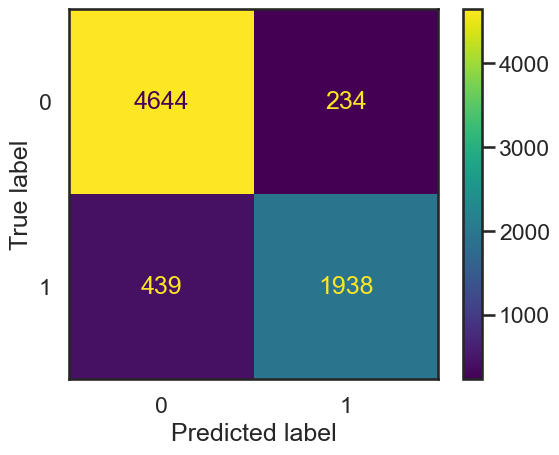

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=RF.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

Plotting ROC and precision-recall curves

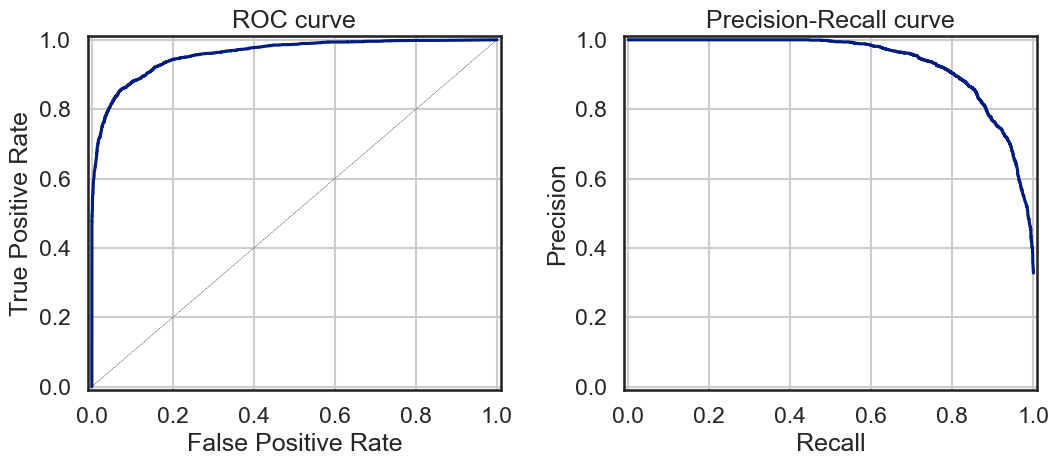

In [ ]:
sns.set_context('talk')

fig, axList = plt.subplots(ncols=2)
fig.set_size_inches(11, 5)

# Get the probabilities for each of the two categories
y_prob = model.predict_proba(x_test)

# Plot the ROC-AUC curve
ax = axList[0]

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
ax.plot(fpr, tpr)
# It is customary to draw a diagonal dotted line in ROC plots.
# This is to indicate completely random prediction. Deviation from this
# dotted line towards the upper left corner signifies the power of the model.
ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3)
ax.set(xlabel='False Positive Rate',
       ylabel='True Positive Rate',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='ROC curve')
ax.grid(True)

# Plot the precision-recall curve
ax = axList[1]

precision, recall, _ = precision_recall_curve(y_test, y_prob[:,1])
ax.plot(recall, precision)
ax.set(xlabel='Recall', ylabel='Precision',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='Precision-Recall curve')
ax.grid(True)

plt.tight_layout()

Plotting the importances of the features

[Text(0, 0.5, 'Relative Importance')]

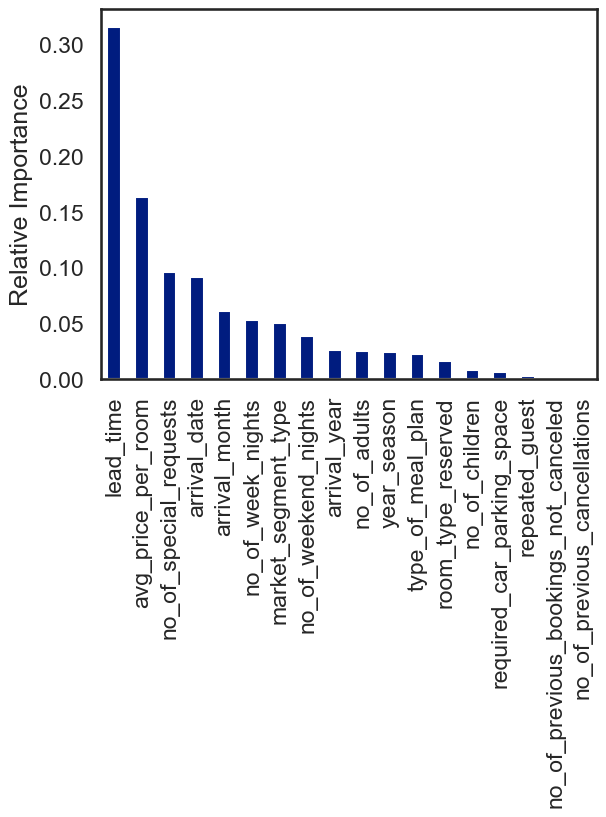

In [ ]:
feature_imp = pd.Series(model.feature_importances_, index=feature_columns).sort_values(ascending=False)

ax = feature_imp.plot(kind='bar')
ax.set(ylabel='Relative Importance')

We can see that the feature year season is quite important

### Boosting

We use XGB (extreme gradient boost) classifier

In [ ]:
# pip install xgboost

In [ ]:
%%time

# gradient boosting - xbg
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss')

boosted_grid = {'n_estimators': [50, 100, 150, 200],
                'max_depth': [4, 8, 12],
                'learning_rate': [0.05, 0.1, 0.15]}

model = GridSearchCV(estimator=xgb, 
                       param_grid=boosted_grid, 
                       n_jobs=-1, 
                       cv=None)
model.fit(x_train, y_train)

print(round(model.score(x_test, y_test), 2))
print(model.best_params_)

0.9
{'learning_rate': 0.15, 'max_depth': 12, 'n_estimators': 200}
Wall time: 2min 40s


In [ ]:
y_train_pred_xgb = model.predict(x_train)
y_test_pred_xgb = model.predict(x_test)

train_test_rf_error = pd.concat([multiple_measure_error(y_train, y_train_pred_xgb, 'train'),
                                 multiple_measure_error(y_test, y_test_pred_xgb, 'test')],
                                axis=1)

train_test_rf_error

train      test
accuracy   0.985734  0.904066
precision  0.981776  0.872727
recall     0.974548  0.827934
f1         0.978148  0.849741

### Logistic regression

basic logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

logr = LogisticRegression().fit(x_train, y_train)

y_pred_logr = logr.predict(x_test)

print(round(accuracy_score(y_test, y_pred_logr), 2))

0.79


Logistic regression with cross validation and with grid that includes ridge (l2) and lasso (l1)

In [ ]:
%%time

from sklearn.linear_model import LogisticRegressionCV

logistic_r = LogisticRegression(random_state=0,penalty='l1',solver='liblinear')
LR_grid = {'penalty': ['l1','l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [50, 100, 150]}

model = GridSearchCV(estimator=logistic_r, param_grid=LR_grid, n_jobs=-1, cv=None)
model.fit(x_train, y_train)

y_pred_logr = model.predict(x_test)

print(round(accuracy_score(y_test, y_pred_logr), 2))
print(model.best_params_)

0.8
{'C': 1.5, 'max_iter': 50, 'penalty': 'l2'}
Wall time: 1min 25s


### KNN

KNN with grid search cross validation

In [ ]:
%%time

# knn

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
KNN_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13],'p': [1, 2]}

model = GridSearchCV(estimator=knn, 
                   param_grid=KNN_grid, 
                   n_jobs=-1, 
                   cv=None)
model.fit(x_train, y_train)

print(round(model.score(x_test, y_test), 2))
print(model.best_params_)

0.83
{'n_neighbors': 3, 'p': 1}
Wall time: 1min 50s


## Balancing the data

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

X = data[feature_columns]
y = data['booking_status']

# Converting to a numpy array
X = X.to_numpy()
y = y.to_numpy()

# Balancing the data
sm = SMOTE(sampling_strategy='minority',random_state=42)
X_sm, y_sm = sm.fit_resample(X, y)

# train and test spliting
x_train, x_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)

In [ ]:
# full decision tree
full_tree = DecisionTreeClassifier(random_state=42)
full_tree = full_tree.fit(x_train, y_train)

print("Number of nodes: ", full_tree.tree_.node_count, ', depth: ', full_tree.tree_.max_depth)

full_tree.fit(x_train, y_train)

# The error on the training and test data sets
y_train_pred = full_tree.predict(x_train)
y_test_pred  = full_tree.predict(x_test)

train_test_full_error = pd.concat([multiple_measure_error(y_train, y_train_pred, 'train'),
                              multiple_measure_error(y_test, y_test_pred, 'test')],
                              axis=1)

train_test_full_error

Number of nodes:  7077 , depth:  39


train      test
accuracy   0.995157  0.898831
precision  0.997169  0.895795
recall     0.993130  0.902948
f1         0.995146  0.899358

Grid search tree

In [ ]:
param_grid = {'max_depth':range(1, full_tree.tree_.max_depth+1, 2),
              'max_features': range(1, len(full_tree.feature_importances_)+1)}

GR = GridSearchCV(DecisionTreeClassifier(random_state=42),
                  param_grid=param_grid,
                  scoring='accuracy',
                  n_jobs=-1)

GR = GR.fit(x_train, y_train)

print("best estimators: ", GR.best_estimator_.tree_.node_count, ' nodes, and depth of ', GR.best_estimator_.tree_.max_depth)


y_train_pred_gr = GR.predict(x_train)
y_test_pred_gr = GR.predict(x_test)

train_test_gr_error = pd.concat([multiple_measure_error(y_train, y_train_pred_gr, 'train'),
                                 multiple_measure_error(y_test, y_test_pred_gr, 'test')],
                                axis=1)

train_test_gr_error

best estimators:  8729  nodes, and depth of  36


train      test
accuracy   0.995157  0.900164
precision  0.997169  0.903093
recall     0.993130  0.896806
f1         0.995146  0.899938

random forest

In [ ]:
RF = RandomForestClassifier(oob_score=True, 
                            random_state=42, 
                            warm_start=True,
                            n_jobs=-1)

oob_list = list()

# Iterate through all of the possibilities for the number of trees
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400, 500, 600]:
    
    # Use this to set the number of trees
    RF.set_params(n_estimators=n_trees)

    # Fit the model
    RF.fit(x_train, y_train)

    # Get the oob error
    oob_error = 1 - RF.oob_score_
    
    # Store it
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

extra trees

In [ ]:
EF = ExtraTreesClassifier(oob_score=True, 
                          random_state=42, 
                          warm_start=True,
                          bootstrap=True,
                          n_jobs=-1)

oob_list = list()

# Iterate through all of the possibilities for the number of trees
for n_trees in [15, 20, 30, 40, 50, 100, 150, 200, 300, 400, 500, 600]:
    
    # Use this to set the number of trees
    EF.set_params(n_estimators=n_trees)
    EF.fit(x_train, y_train)

    # oob error
    oob_error = 1 - EF.oob_score_
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob': oob_error}))

et_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

et_oob_df

oob
n_trees          
15.0     0.093353
20.0     0.086741
30.0     0.082052
40.0     0.079361
50.0     0.078695
100.0    0.075876
150.0    0.075825
200.0    0.075159
300.0    0.074262
400.0    0.074083
500.0    0.074262
600.0    0.074006

Plotting the results of the models for each number of trees

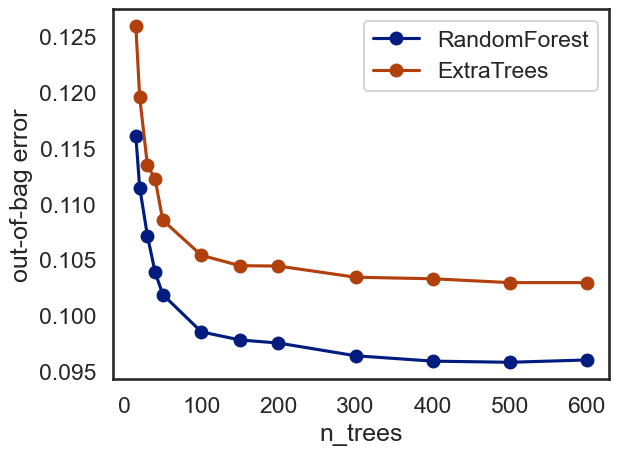

In [ ]:
sns.set_context('talk')
sns.set_palette('dark')
sns.set_style('white')

ax = oob_df.plot(marker='o')
ax.set(ylabel='out-of-bag error');

Based on oob results and efficiency, the model we chose is Random forest with 300 estimators:

In [ ]:
%%time

model = RF.set_params(n_estimators=300)

y_pred = model.predict(x_test)

y_train_pred_rf = model.predict(x_train)
y_test_pred_rf = model.predict(x_test)

train_test_rf_error = pd.concat([multiple_measure_error(y_train, y_train_pred_rf, 'train'),
                                 multiple_measure_error(y_test, y_test_pred_rf, 'test')],
                                axis=1)

train_test_rf_error

Wall time: 1.64 s


train      test
accuracy   0.995157  0.931632
precision  0.996453  0.947380
recall     0.993848  0.914210
f1         0.995149  0.930499

confusion matrix

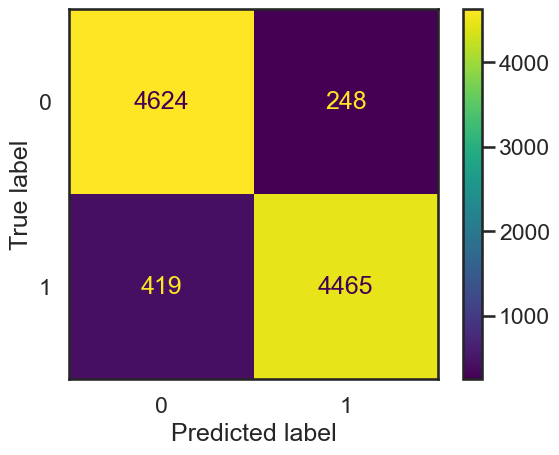

In [ ]:
cm = confusion_matrix(y_test, y_pred, labels=RF.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

We got a better model!

**We got more false positive values than false negative values, which means that the algorithm prefers empty rooms rather than overbooking**

Plotting ROC and precision-recall curves

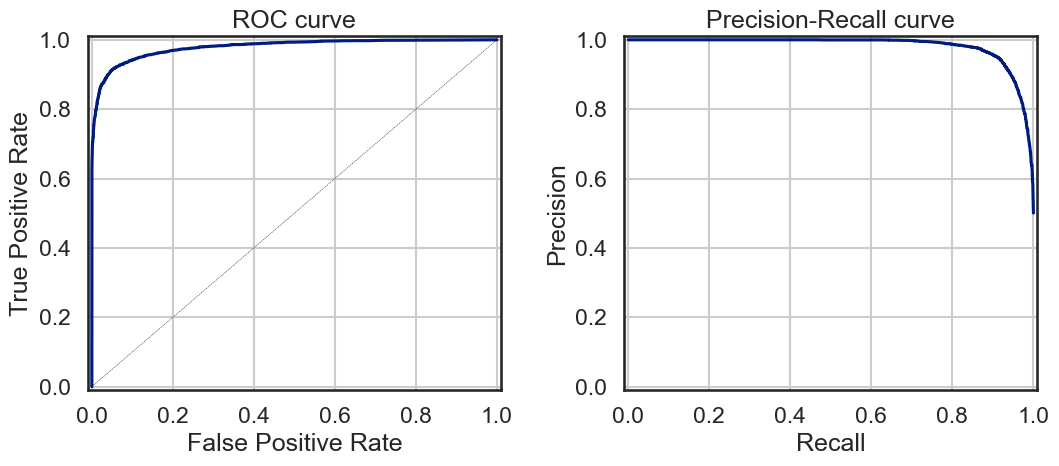

In [ ]:
sns.set_context('talk')

fig, axList = plt.subplots(ncols=2)
fig.set_size_inches(11, 5)

# Get the probabilities for each of the two categories
y_prob = model.predict_proba(x_test)

# Plot the ROC-AUC curve
ax = axList[0]

fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1])
ax.plot(fpr, tpr)

ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3)
ax.set(xlabel='False Positive Rate',
       ylabel='True Positive Rate',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='ROC curve')
ax.grid(True)

# Plot the precision-recall curve
ax = axList[1]

precision, recall, _ = precision_recall_curve(y_test, y_prob[:,1])
ax.plot(recall, precision)
ax.set(xlabel='Recall', ylabel='Precision',
       xlim=[-.01, 1.01], ylim=[-.01, 1.01],
       title='Precision-Recall curve')
ax.grid(True)

plt.tight_layout()

The indices have improved!

Boosting - XGB

In [ ]:
%%time

xgb = XGBClassifier(random_state=0, use_label_encoder=False, eval_metric='logloss')

boosted_grid = {'n_estimators': [50, 100, 150, 200],
                'max_depth': [4, 8, 12],
                'learning_rate': [0.05, 0.1, 0.15]}

model = GridSearchCV(estimator=xgb, 
                       param_grid=boosted_grid, 
                       n_jobs=-1, 
                       cv=None)
model.fit(x_train, y_train)

print(round(model.score(x_test, y_test), 2))
print(model.best_params_)

y_train_pred_xgb = model.predict(x_train)
y_test_pred_xgb = model.predict(x_test)

train_test_rf_error = pd.concat([multiple_measure_error(y_train, y_train_pred_xgb, 'train'),
                                 multiple_measure_error(y_test, y_test_pred_xgb, 'test')],
                                axis=1)

train_test_rf_error

0.93
{'learning_rate': 0.15, 'max_depth': 12, 'n_estimators': 200}
Wall time: 4min 35s


train      test
accuracy   0.990288  0.928659
precision  0.990159  0.940657
recall     0.990413  0.915233
f1         0.990286  0.927771

Logistic regression with cross-validation, Ridge and Lasso


In [ ]:
%%time

logistic_r = LogisticRegression(random_state=0,penalty='l1',solver='liblinear')
LR_grid = {'penalty': ['l1','l2'],
           'C': [0.25, 0.5, 0.75, 1, 1.25, 1.5],
           'max_iter': [50, 100, 150]}

model = GridSearchCV(estimator=logistic_r, param_grid=LR_grid, n_jobs=-1, cv=None)
model.fit(x_train, y_train)

y_pred_logr = model.predict(x_test)

print(round(accuracy_score(y_test, y_pred_logr), 2))
print(model.best_params_)

0.77
{'C': 0.25, 'max_iter': 50, 'penalty': 'l1'}
Wall time: 4min 18s


The balancing didn't improve the logistic regression results

KNN

In [ ]:
%%time

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
KNN_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11, 13],'p': [1, 2]}

model = GridSearchCV(estimator=knn, 
                   param_grid=KNN_grid, 
                   n_jobs=-1, 
                   cv=None)
model.fit(x_train, y_train)

print(round(model.score(x_test, y_test), 2))
print(model.best_params_)

0.89
{'n_neighbors': 1, 'p': 1}
Wall time: 2min 36s


## k-means

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

data2=data.copy()
data2[feature_columns] = sc.fit_transform(data2[feature_columns])

data2.head()

Booking_ID  no_of_adults  no_of_children  no_of_weekend_nights  \
0   INN00001      0.298893        -0.26147              0.217401   
1   INN00002      0.298893        -0.26147              1.365993   
2   INN00003     -1.628975        -0.26147              1.365993   
3   INN00004      0.298893        -0.26147             -0.931190   
4   INN00005      0.298893        -0.26147              0.217401   

   no_of_week_nights  type_of_meal_plan  required_car_parking_space  \
0          -0.144803          -0.511039                   -0.178819   
1           0.563972           1.065988                   -0.178819   
2          -0.853578          -0.511039                   -0.178819   
3          -0.144803          -0.511039                   -0.178819   
4          -0.853578           1.065988                   -0.178819   

   room_type_reserved  lead_time  arrival_year  arrival_month  arrival_date  \
0           -0.434572   1.614896     -2.137469       0.839242     -1.555662   
1           -0.434572  -0.933701      0.467843       1.164990     -1.098013   
2           -0.434572  -0.980250      0.467843      -1.766747      1.419055   
3           -0.434572   1.463610      0.467843      -0.789501      0.503757   
4           -0.434572  -0.433291      0.467843      -1.115250     -0.525952   

   market_segment_type  repeated_guest  no_of_previous_cancellations  \
0            -1.243838        -0.16221                     -0.063393   
1             0.302063        -0.16221                     -0.063393   
2             0.302063        -0.16221                     -0.063393   
3             0.302063        -0.16221                     -0.063393   
4             0.302063        -0.16221                     -0.063393   

   no_of_previous_bookings_not_canceled  avg_price_per_room  \
0                             -0.087456           -1.095033   
1                             -0.087456            0.092806   
2                             -0.087456           -1.237528   
3                             -0.087456           -0.097567   
4                             -0.087456           -0.254312   

   no_of_special_requests  booking_status  year_season  
0                -0.78814               0    -1.146275  
1                 0.48376               0    -1.146275  
2                -0.78814               1    -0.329854  
3                -0.78814               1     0.486566  
4                -0.78814               1     0.486566

In [ ]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=2, random_state=42)
km = km.fit(data2[feature_columns])

data2['kmeans'] = km.predict(data2[feature_columns])

In [ ]:
(data2[['booking_status','kmeans']]
 .groupby(['booking_status','kmeans'])
 .size()
 .to_frame()
 .rename(columns={0:'number'}))

number
booking_status kmeans        
0              0        13156
               1        11234
1              0         7190
               1         4695

Create and fit a range of models


In [ ]:
km_list = list()

for clust in range(1,20):
    km = KMeans(n_clusters=clust, random_state=42)
    km = km.fit(data2[feature_columns])
    
    km_list.append(pd.Series({'clusters': clust, 
                              'inertia': km.inertia_,
                              'model': km}))

Plotting the inertia graph

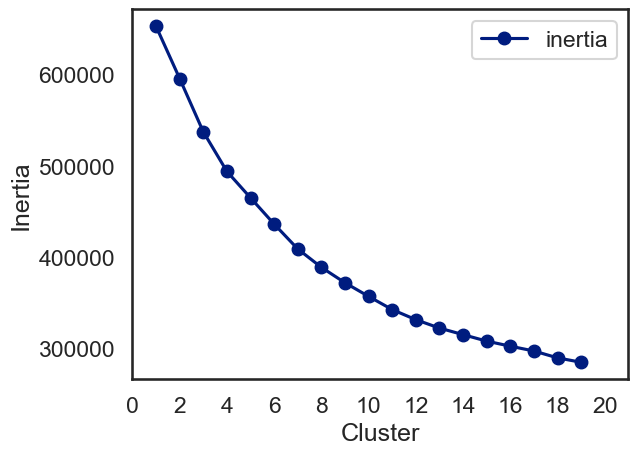

In [ ]:
plot_data = (pd.concat(km_list, axis=1).T[['clusters','inertia']].set_index('clusters'))

ax = plot_data.plot(marker='o',ls='-')
ax.set_xticks(range(0,21,2))
ax.set_xlim(0,21)
ax.set(xlabel='Cluster', ylabel='Inertia');

Adding kmeans to the feature_columns

In [ ]:
feature_columns += ['kmeans']

feature_columns

['no_of_adults',
 'no_of_children',
 'no_of_weekend_nights',
 'no_of_week_nights',
 'type_of_meal_plan',
 'required_car_parking_space',
 'room_type_reserved',
 'lead_time',
 'arrival_year',
 'arrival_month',
 'arrival_date',
 'market_segment_type',
 'repeated_guest',
 'no_of_previous_cancellations',
 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room',
 'no_of_special_requests',
 'year_season',
 'kmeans']

In [ ]:
from sklearn.cluster import AgglomerativeClustering

ag = AgglomerativeClustering(n_clusters=2, linkage='ward', compute_full_tree=True)
ag = ag.fit(data2[feature_columns])
data2['agglom'] = ag.fit_predict(data2[feature_columns])

In [ ]:
(data2[['booking_status', 'agglom', 'kmeans']]
 .groupby(['booking_status', 'agglom', 'kmeans'])
 .size()
 .to_frame()
 .rename(columns={0:'number'}))

number
booking_status agglom kmeans        
0              0      0           69
                      1           38
               1      0         6563
               2      0          332
                      1          450
...                              ...
1              16     0           75
                      1           62
               17     0            4
               18     0          195
                      1          143

[62 rows x 1 columns]

In [ ]:
feature_columns += ['agglom']

In [ ]:
from sklearn.metrics import roc_auc_score

X = data2[feature_columns]
X_without_kmeans = X.drop(['kmeans','agglom'], axis=1)
y = data2['booking_status']

def kmeans_results(X, y, label):
    X = X.to_numpy()
    y = y.to_numpy()
    
    # Balancing the data
    sm = SMOTE(sampling_strategy='minority',random_state=42)
    X_sm, y_sm = sm.fit_resample(X, y)
    
    # train and test spliting
    x_train, x_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)
    
    estimator = RandomForestClassifier(oob_score=True, random_state=42, warm_start=True, n_jobs=-1)
    estimator.fit(x_train, y_train)
    
    y_predicted = estimator.predict(x_test)
    y_scored = estimator.predict_proba(x_test)[:, 1]

    return pd.Series({'accuracy':accuracy_score(y_test, y_predicted),
                            'roc_auc': roc_auc_score(y_test, y_scored)},
                      name=label)
    



kmeans_res = pd.concat([kmeans_results(X, y, 'with kmeans'),
                        kmeans_results(X_without_kmeans, y, 'without kmeans')],
                        axis=1)

kmeans_res

with kmeans  without kmeans
accuracy     0.925482        0.926199
roc_auc      0.977169        0.977333

kmeans didn't improve the algorithm

In [ ]:
feature_columns.remove('kmeans')
feature_columns.remove('agglom')

### PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

X = data[feature_columns]
y = data['booking_status']

X = X.to_numpy()
y = y.to_numpy()
    
# Balancing the data
sm = SMOTE(sampling_strategy='minority',random_state=42)
X_sm, y_sm = sm.fit_resample(X, y)

# train and test spliting
x_train, x_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)

# we use random forest
def get_avg_score(n):
    pipe = [
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n)),
        ('estimator', RandomForestClassifier(oob_score=True, random_state=42, warm_start=True, n_jobs=-1))
    ]
    pipe = Pipeline(pipe)
    pipe.fit(x_train, y_train)
    return pd.Series({'accuracy_score': accuracy_score(y_test, pipe.predict(x_test))}, name=n)

score_df = pd.DataFrame(get_avg_score(n) for n in range(1, 19))

score_df.sort_values(by='accuracy_score', ascending=False).head(8)

accuracy_score
18        0.908262
17        0.904162
15        0.903444
16        0.902829
14        0.899856
13        0.899036
12        0.898626
11        0.888274

plotting the accuracy, using random forest

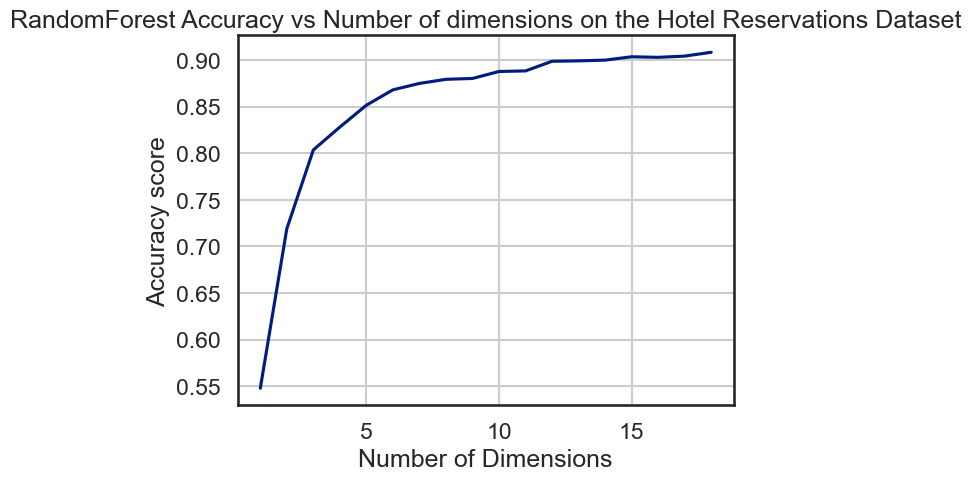

In [ ]:
sns.set_context('talk')

ax = plt.axes()
ax.plot(range(1, 19), score_df)
ax.set(xlabel='Number of Dimensions',
       ylabel='Accuracy score',
       title='RandomForest Accuracy vs Number of dimensions on the Hotel Reservations Dataset')
ax.grid(True)

# Conclusion

**The data engineering improved the models results** (such as adding the year season feature and removing unrelevant features).
> 
**Balancing the data improved the results**; without balancing the best model was with accuracy of **0.9**, and with the balancing we got accuracy of **0.93**.

### Decision trees

**Best accuracy score: 0.93**
> 
with balancing,
> 
using random forest with 300 estimators
> 
Time taken: 

### KNN

Best accuracy score: 
> 
with balancing,
> 
using random forest with 300 estimators
> 
Time taken: 

### Logistic regression

**Best accuracy score: 0.8**
> 
witout balancing,
> 
using ridge (l2) with c=1.5
> 
max iterators of 50
> 
Time taken: 1min 21s